In [1]:
import numpy as np
import pandas as pd
import sys
from timeit import default_timer as timer
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("/Users/hakunahahannah/Documents/Projects/Spiking/Analysis/SpikeAnalysisToolbox/")

import spikeAnalysisToolsV2.data_loading as data
import spikeAnalysisToolsV2.firing_rates as firing
import spikeAnalysisToolsV2.helper as helper
import spikeAnalysisToolsV2.overviews as overview
import spikeAnalysisToolsV2.plotting as spikeplot
import spikeAnalysisToolsV2.information_scores as info

In [3]:
## set the Masterpath to the folder where your output is saved

masterpath = "/Users/hakunahahannah/Documents/Projects/Spiking/Build/output"
## set the subfolder to the Simulation you want to analyse 

subfolders = [
     "20Ex20IdNetworkTEST_400_epochs"
            ]
## if more than the inital epoch is needed *1 needs to be run
extensions = [
            "initial",
             ] 

object_list = data.load_testing_stimuli_info(masterpath+"/" + subfolders[0]) #assuming all the subfolders have the same
n_stimuli = np.sum(obj['count'] for obj in object_list)

#current_index=0
#object_indices = []
#for obj in object_list:
#    object_indices.append(list(range(current_index, current_index + obj['count'])))
#    current_index += obj["count"]

# info_neurons is just an array of the information from above. This makes it easier to run the functions and pass the information. 
# info_times same for times
network_architecture = dict(
    num_exc_neurons_per_layer = 64*64,
    num_inh_neurons_per_layer = 32*32,
    num_layers = 4,
    #total_per_layer = num_exc_neurons_per_layer + num_inh_neurons_per_layer,
    #total_network = total_per_layer * num_layers,
    #num_stimuli = 16
)

info_times = dict(
    length_of_stimulus = 2.0,
    num_stimuli = n_stimuli,
    time_start = 1.5,
    time_end = 1.9
)

#objects_in_training = [obj['indices'] for obj in object_list]
# getting the information
# objects_in_training = [
#     object_list[0]['indices'] + object_list[1]['indices'] + object_list[2]['indices'] + object_list[3]['indices'],
#     object_list[4]['indices'] + object_list[5]['indices'] + object_list[6]['indices'] + object_list[7]['indices']
# ]
objects_in_training = [obj['indices'] for obj in object_list]
# These Objects were bound together in training with temporal trace. so it should have learned information about them. 
assert(np.array(objects_in_training).max()== n_stimuli-1)

In [4]:
spikes = data.load_spikes_from_subfolders(masterpath, subfolders, extensions, False)

Start


In [5]:
start = timer()
rates_subfolders = firing.calculate_rates_subfolder(
    spikes,
    network_architecture, 
    info_times)
print("Calulating Firing Rates took {}s".format(timer() - start))

Calulating Firing Rates took 13.00840115873143s


# Explanation
### Motivation
We notice that there is less information about objects that are presented closer to the border. I assume it is because of less outgoing connections from neurons situated at the border. Here we invastigate if and how that is the case.
### Hypothesis
The fewer outgoing connections from border neurons are most prominent in synapses of type i2e_L. Therefore I hypothesised:  
1. there is less inhibition caused by border stimuli
2. this leads to (a) worse learning or (b) less sparsity from the begining

### Evidence
  * (-) There is no overall lower FR for border stimuli, which speaks agains this. But presumably there is also less activation for border stimuli because there are less outgoing e2e_FF e2e_L connections as well. 
  * (+) In the first 2 layers the inhibitory activity is a lot (compared to std) smaller for obj 0. while the excitatory activity is only a little bit smaller for obj 0 compared to obj 1! [click me](#mean_layers)
  * (+) see discoveries

### Discoveries
FR=0 is the least distributed Firing Rate a neuron can have. Therefore neurons that have FR(obj0)=0 and FR(obj1)=1 have the highest information about object 0. -> if obj0 causes less (specific) inhibition, then there will be less neurons that have this kind of response -> less information about obj0 [click me](#higher_fr_for_obj_0)  
-> I suppose this effect should be there even before learning

## Looking at Firing Rates

In [123]:
last_epoch_exc, last_epoch_inh = helper.nested_list_of_stimuli_2_np(rates_subfolders[0][-1])

### Animation of Firing Rates in each stimulus

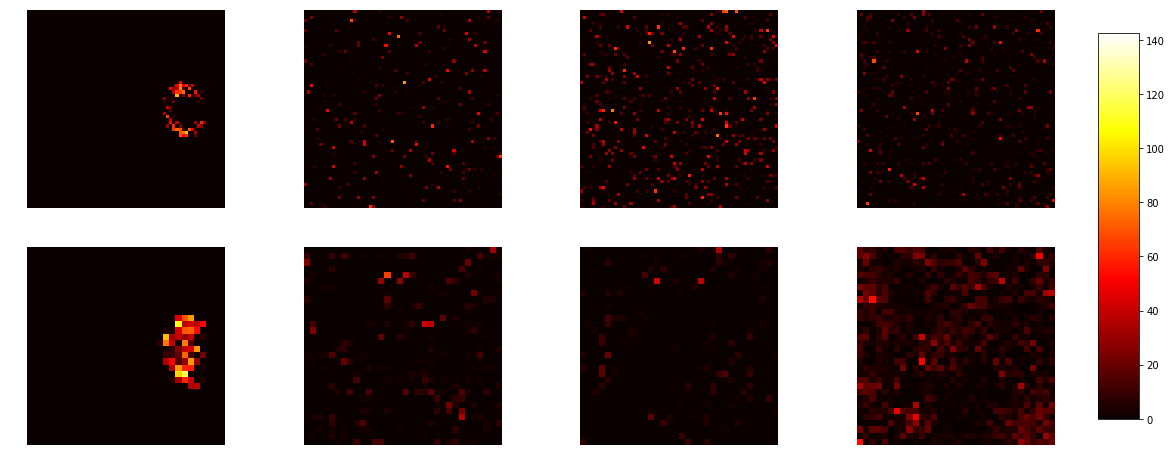

In [124]:
from matplotlib import rc
from IPython.display import HTML
rc('animation', html='html5')

ani = spikeplot.animate_neuron_value_development(last_epoch_exc, last_epoch_inh)
HTML(ani.to_html5_video())

#### Mean over presentations for Object 1 - Mean over presentations for Object 0

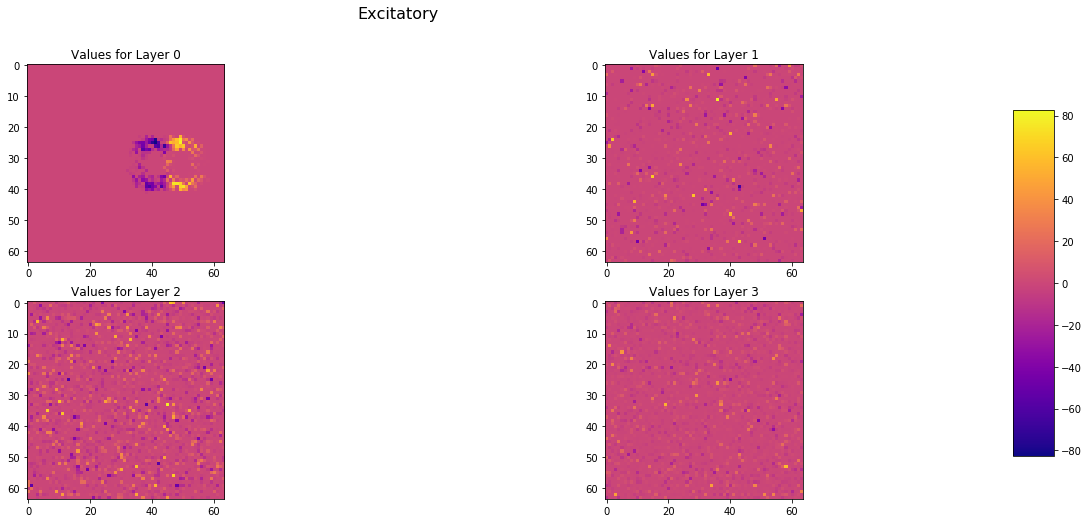

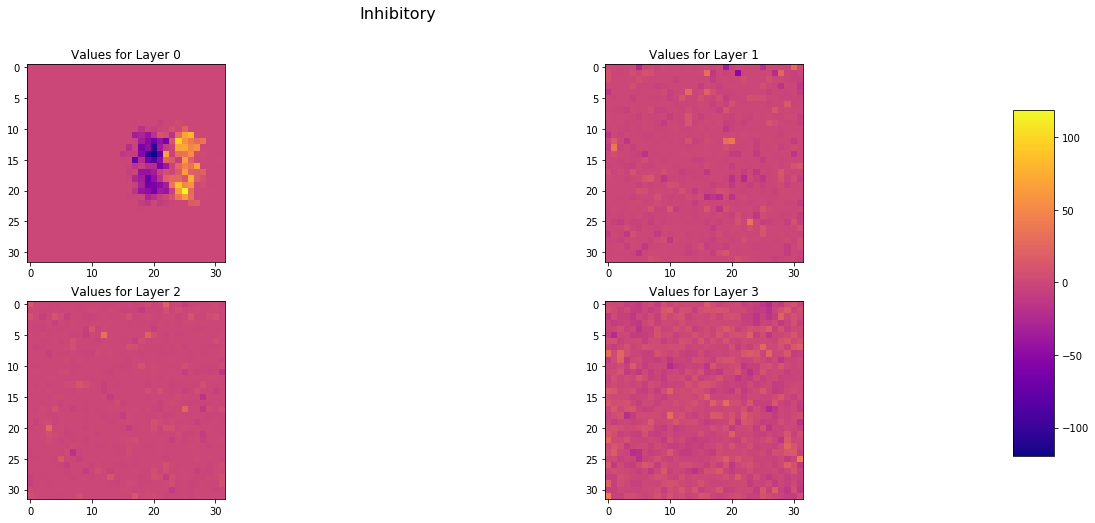

In [125]:
import numpy as np
exc_mean_obj1 = np.mean(last_epoch_exc[objects_in_training[1], :, :], axis=0)
exc_mean_obj0 = np.mean(last_epoch_exc[objects_in_training[0], :, :], axis=0)

inh_mean_obj1 = np.mean(last_epoch_inh[objects_in_training[1], :, :], axis=0)
inh_mean_obj0 = np.mean(last_epoch_inh[objects_in_training[0], :, :], axis=0)

diff_exc = exc_mean_obj1 - exc_mean_obj0
diff_inh = inh_mean_obj1 - inh_mean_obj0
spikeplot.show_values_all_layer(diff_exc, "Excitatory")
spikeplot.show_values_all_layer(diff_inh, "Inhibitory")

#### Mean per Layer by Presentation

In [126]:
exc_mean_within_layer = np.mean(last_epoch_exc, axis=2)
exc_mean_within_layer.shape

(144, 4)

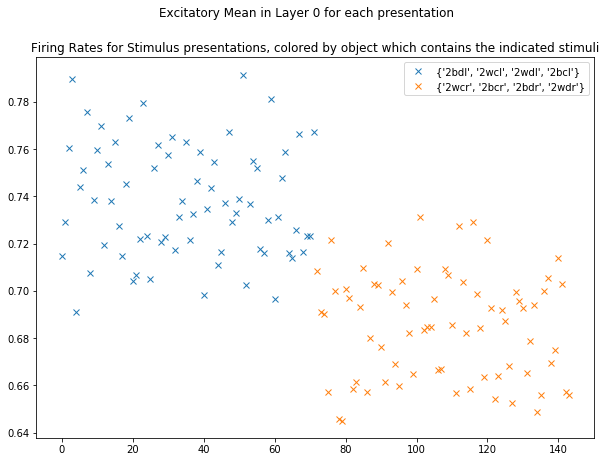

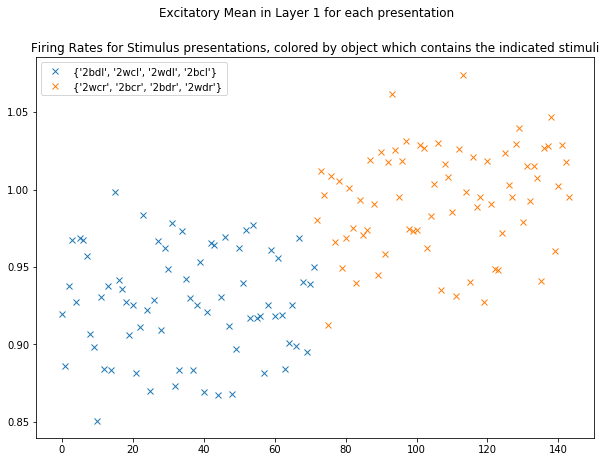

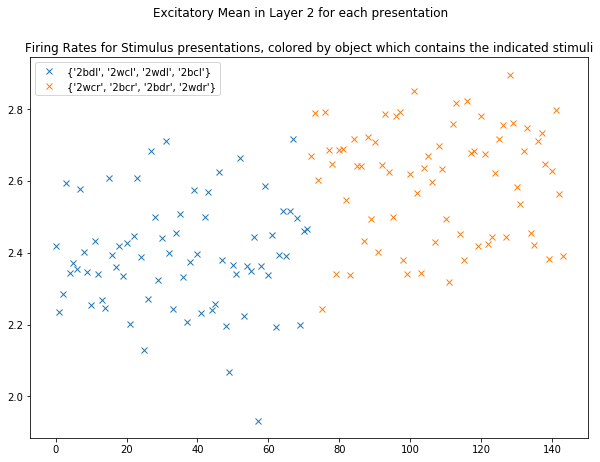

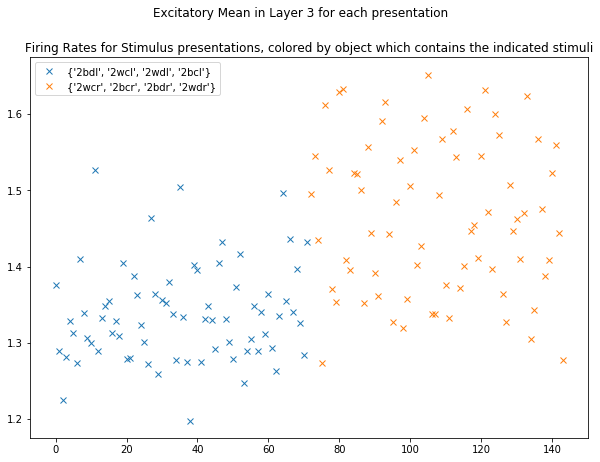

In [127]:
for i in range(4):
    spikeplot.plot_firing_rates_colored_by_object(exc_mean_within_layer[:, i], object_list, "Excitatory Mean in Layer {} for each presentation".format(i))

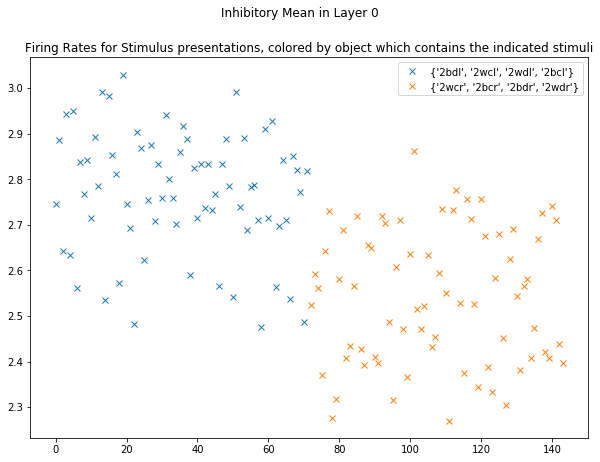

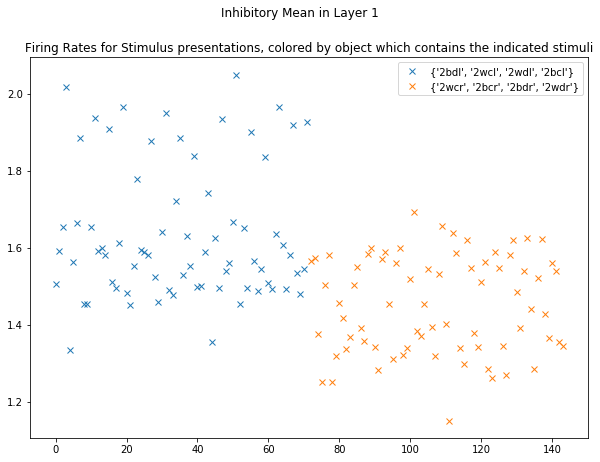

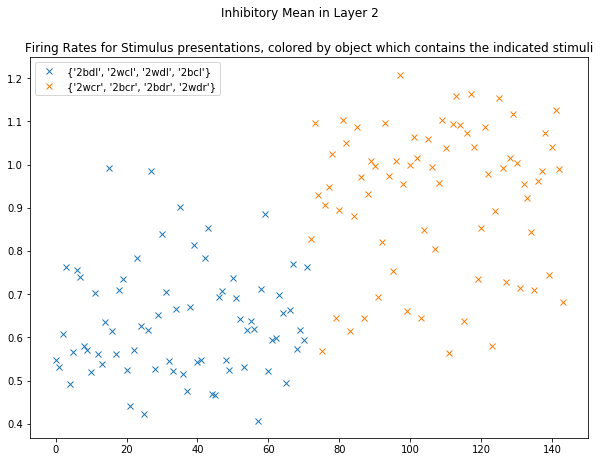

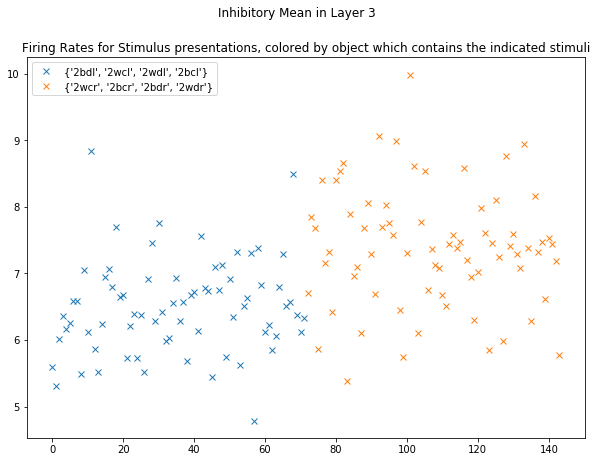

In [128]:
inh_mean_within_layer = np.mean(last_epoch_inh, axis=2)
for i in range(4):
    spikeplot.plot_firing_rates_colored_by_object(inh_mean_within_layer[:, i], object_list, "Inhibitory Mean in Layer {}".format(i))

#### Mean vs Std by Presentation

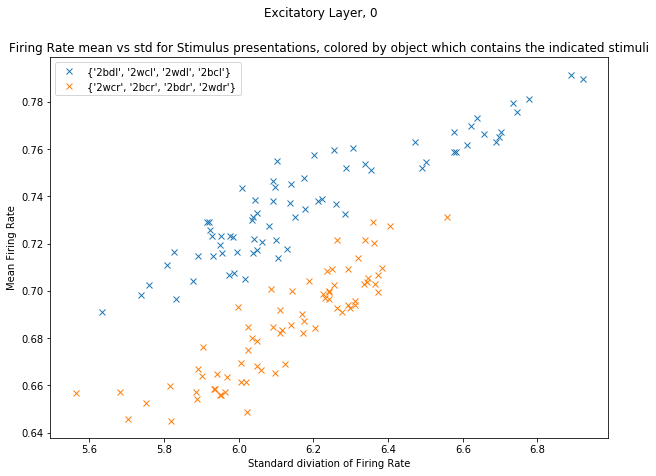

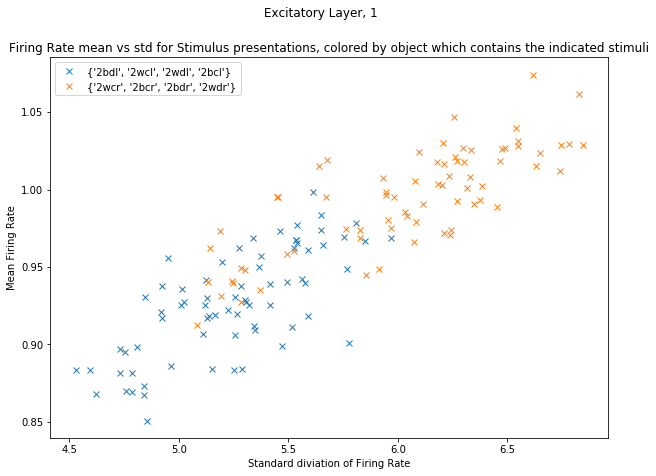

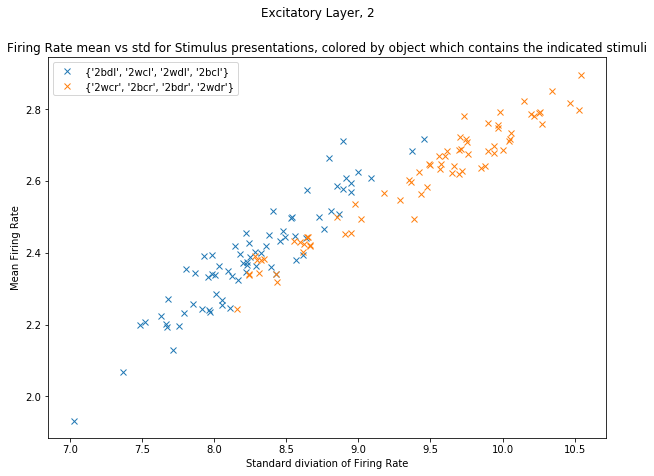

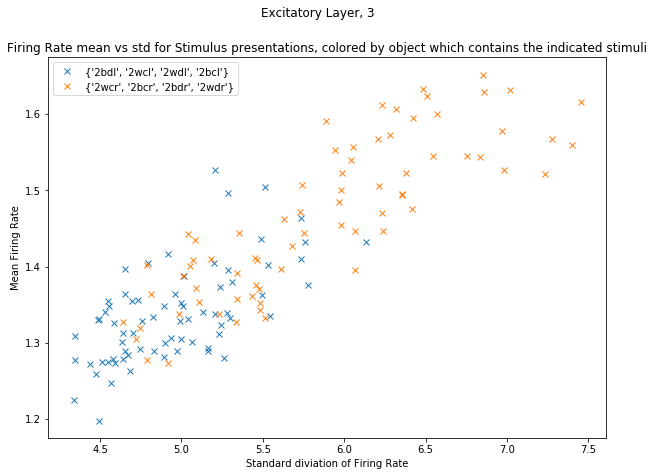

In [129]:
for i in range(4):
    spikeplot.plot_firing_rates_std_vs_mean_colored_by_object(last_epoch_exc[:, i, :], object_list, "Excitatory Layer, {}".format(i))

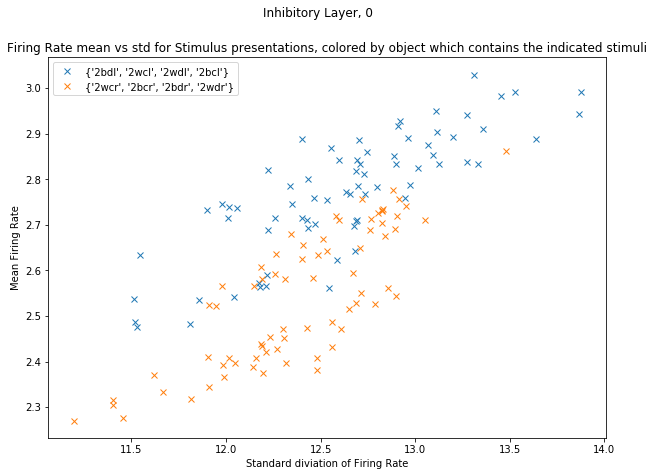

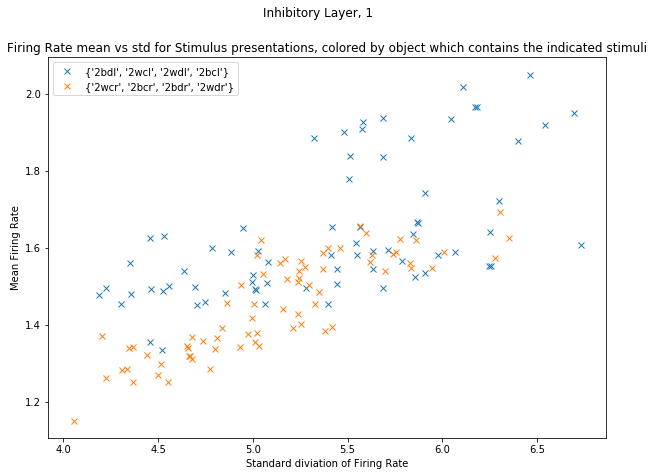

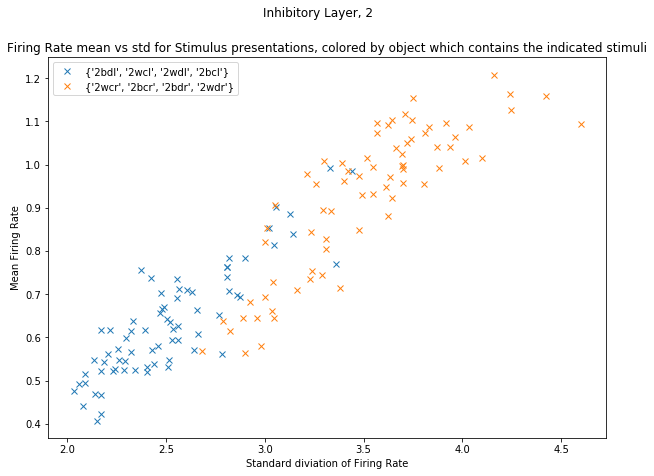

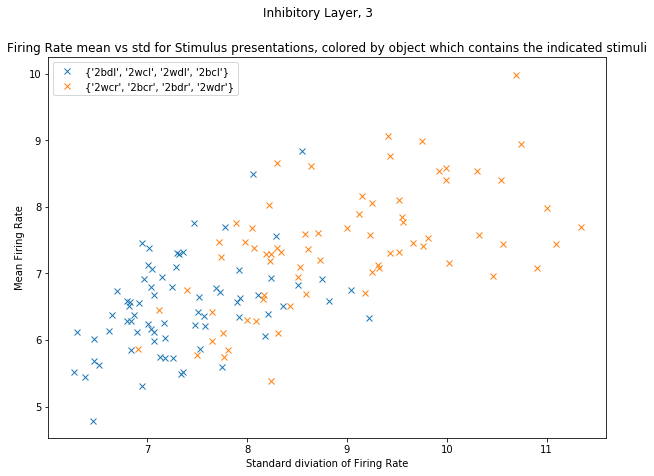

In [130]:
for i in range(4):
    spikeplot.plot_firing_rates_std_vs_mean_colored_by_object(last_epoch_inh[:, i, :], object_list, "Inhibitory Layer, {}".format(i))

#### Mean within Layer and within presentations of Object 
<a id="mean_layers"></a>

In [131]:
objects_in_training
import scipy.stats as scistats

def stats_of_layer_means_over_presentations(mean_within_layer, objects):
    mean_within_object_0 = np.mean(mean_within_layer[objects[0], :], axis=0)
    mean_within_object_1 = np.mean(mean_within_layer[objects[1], :], axis=0)
    assert(mean_within_object_0.shape == (4,))

    std_within_object_0 = np.std(mean_within_layer[objects[0], :], axis=0)
    std_within_object_1 = np.std(mean_within_layer[objects[1], :], axis=0)
    
    _t, p_score = scistats.ttest_ind(mean_within_layer[objects[0]], mean_within_layer[objects[1]], equal_var=False)

    print("For each layer the mean across presentations of the same object over the layer FR mean. And the std of the means for the layer response per presentation")

    import pandas as pd

    table = pd.DataFrame(data={'mean obj 0': mean_within_object_0, 
                           'mean obj 1': mean_within_object_1,
                           'std obj 0': std_within_object_0,
                           'std obj 1': std_within_object_1,
                            'p of beeing from same': p_score
                           }, index=['L0', 'L1', 'L2', 'L3'])

    return table

In [132]:
print("Excitatory")
stats_of_layer_means_over_presentations(exc_mean_within_layer, objects_in_training)

Excitatory
For each layer the mean across presentations of the same object over the layer FR mean. And the std of the means for the layer response per presentation


mean obj 0  mean obj 1  p of beeing from same  std obj 0  std obj 1
L0    0.737915    0.685137           1.085676e-27   0.023716   0.022200
L1    0.926573    0.993983           3.593591e-23   0.033971   0.033336
L2    2.389764    2.602175           9.759442e-14   0.150571   0.156144
L3    1.337738    1.465378           2.560474e-15   0.062913   0.100169

In [133]:
print("Inhibitory")
stats_of_layer_means_over_presentations(inh_mean_within_layer, objects_in_training)

Inhibitory
For each layer the mean across presentations of the same object over the layer FR mean. And the std of the means for the layer response per presentation


mean obj 0  mean obj 1  p of beeing from same  std obj 0  std obj 1
L0    2.770318    2.543064           2.091262e-17   0.132145   0.146032
L1    1.636658    1.453824           4.657866e-11   0.173766   0.125378
L2    0.634833    0.924276           6.495078e-22   0.125863   0.167997
L3    6.497192    7.384576           8.456102e-10   0.700642   0.889201

In the first 2 layers the inhibitory activity is a lot (compared to std) smaller for obj 0. while the excitatory activity is only a little bit smaller for obj 0 compared to obj 1! 

### Looking at single Neurons

In [134]:
info_exc, info_inh = info.firing_rates_to_single_cell_information(rates_subfolders[0][-1], objects_in_training, n_bins=3, calc_inhibitory=True)
info_exc.shape

/Users/clemens/Documents/Code/AnalysisToolbox/spikeAnalysisToolsV2/information_scores.py:205: RuntimeWarning: invalid value encountered in true_divide
  exc_info = single_cell_information(exc_table)
/Users/clemens/Documents/Code/AnalysisToolbox/spikeAnalysisToolsV2/information_scores.py:205: RuntimeWarning: divide by zero encountered in log2
  exc_info = single_cell_information(exc_table)
/Users/clemens/Documents/Code/AnalysisToolbox/spikeAnalysisToolsV2/information_scores.py:209: RuntimeWarning: invalid value encountered in true_divide
  inh_info = single_cell_information(inh_table)
/Users/clemens/Documents/Code/AnalysisToolbox/spikeAnalysisToolsV2/information_scores.py:209: RuntimeWarning: divide by zero encountered in log2
  inh_info = single_cell_information(inh_table)


(2, 4, 4096)

**A few layer 2 neurons with high information about 'object left of loc1' or 'object right of loc1'**

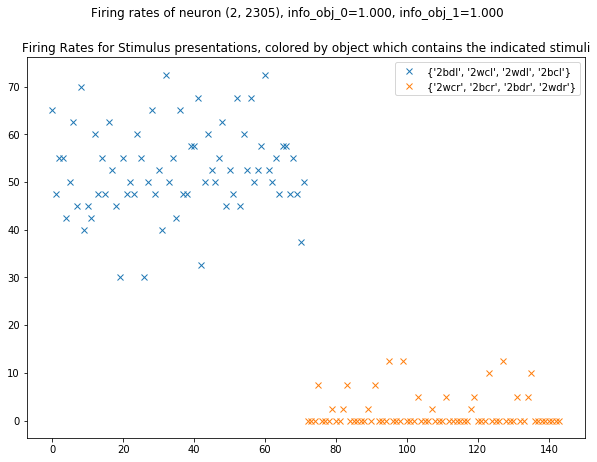

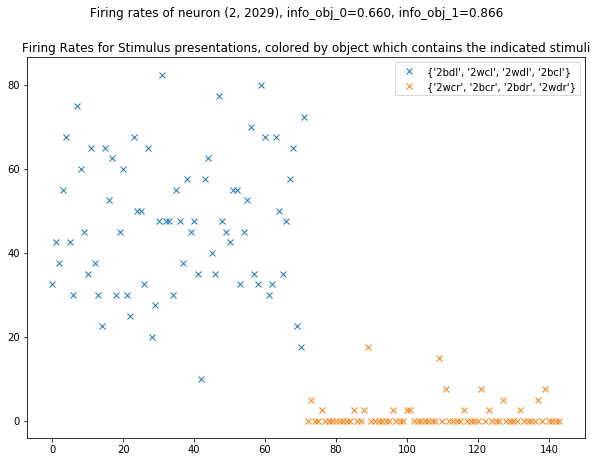

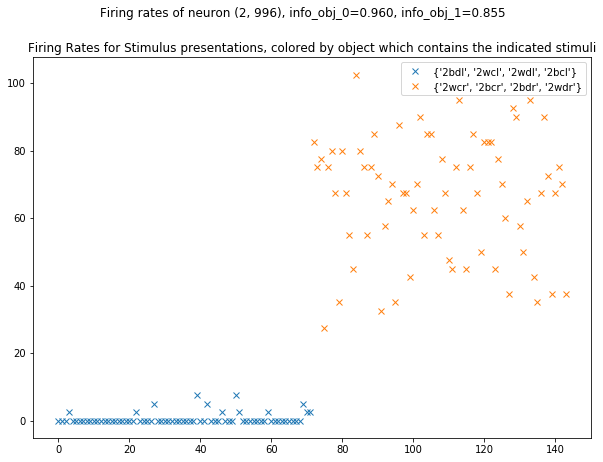

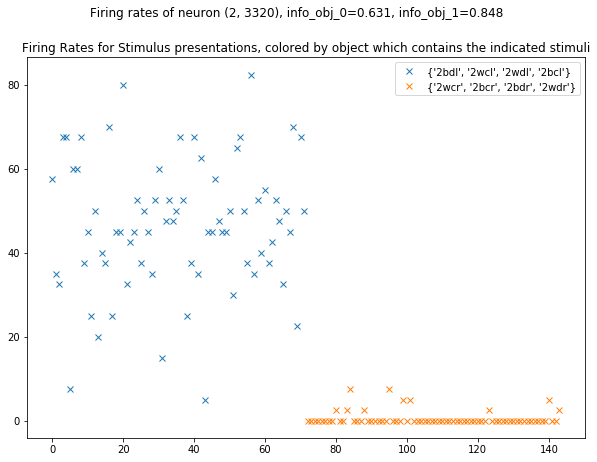

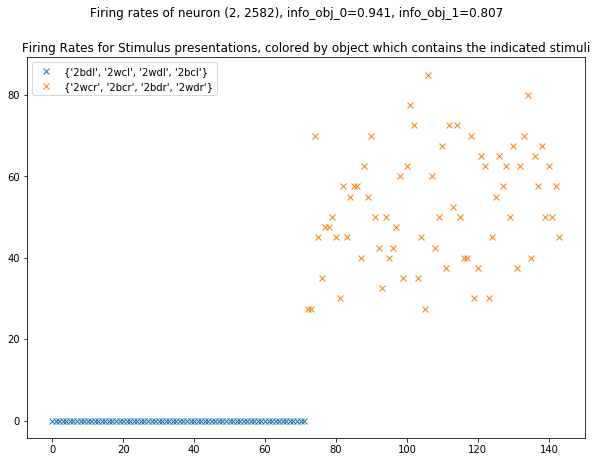

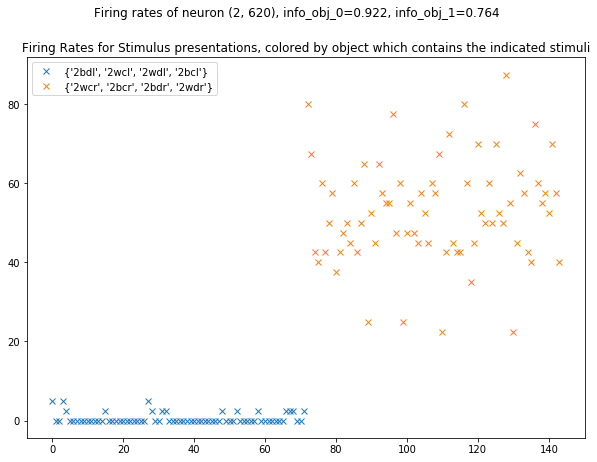

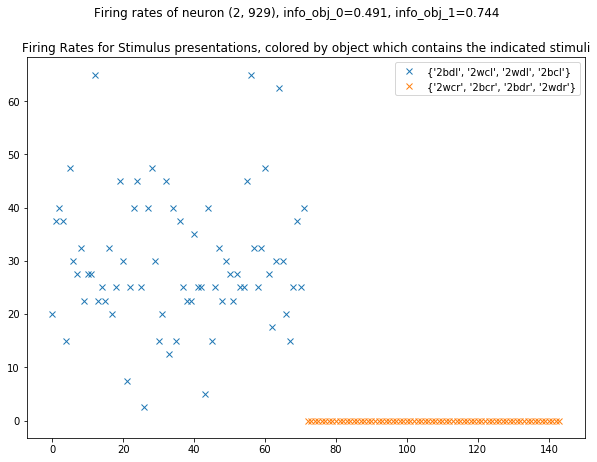

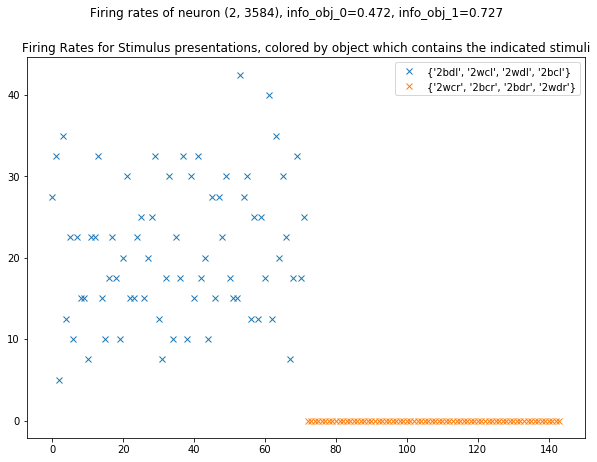

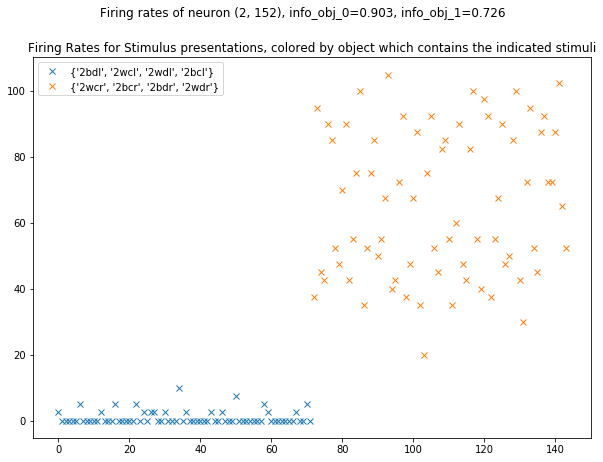

In [135]:
layer, object_id = 1, 1
list_of_interesting_neurons = np.argsort(info_exc[object_id, layer, :])[:-10:-1]
for interesting_neuron_id in list_of_interesting_neurons:
    title = "Firing rates of neuron (2, {}), info_obj_0={:.3f}, info_obj_1={:.3f}".format(interesting_neuron_id, info_exc[0,layer,interesting_neuron_id], info_exc[1,layer,interesting_neuron_id])
    response_of_that = last_epoch_exc[:, layer, interesting_neuron_id]
    spikeplot.plot_firing_rates_colored_by_object(response_of_that, object_list, title)

#### A few random Layer 2 neurons

## Informative Neurons: For which object is the FR higher?
##### How Asymetric is the information in generall?

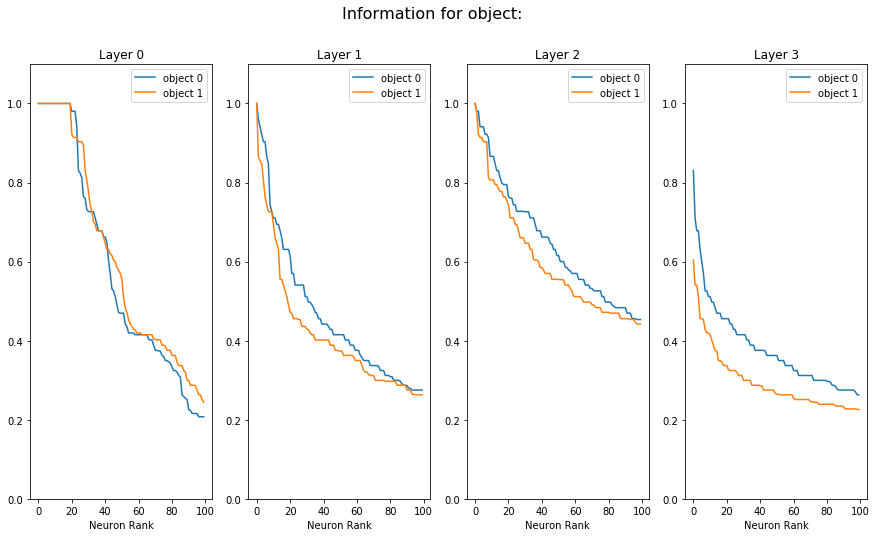

In [136]:
spikeplot.plot_ranked_neurons(info_exc, "Information for object: ", 100, ["object 0", "object 1"])

##### Top n neurons colored. by prefered object (i.e. the object they have higher firing rate for)
left object 0, right object 1
highest information 200 neurons decreasing (left for object 0, right for object 1)
each point corresponds to a neuron
each point is colored according to wether the firing rate for obj 1 is higher or for object 0 or roughly similar

In [137]:
def make_line_collection_list(points_one, points_two):
    """ make list containing lines between two sets of values
    :arg one: each is a list of values, it will give coordinates for lines between each element of one and two 
    :arg two:
    """
    assert(len(points_one) == len(points_two))
    collector = list()
    for i in range(len(points_one)):
        a = (float(i), points_one[i])
        b = (float(i), points_two[i])
        collector.append([a,b])
    return collector
    

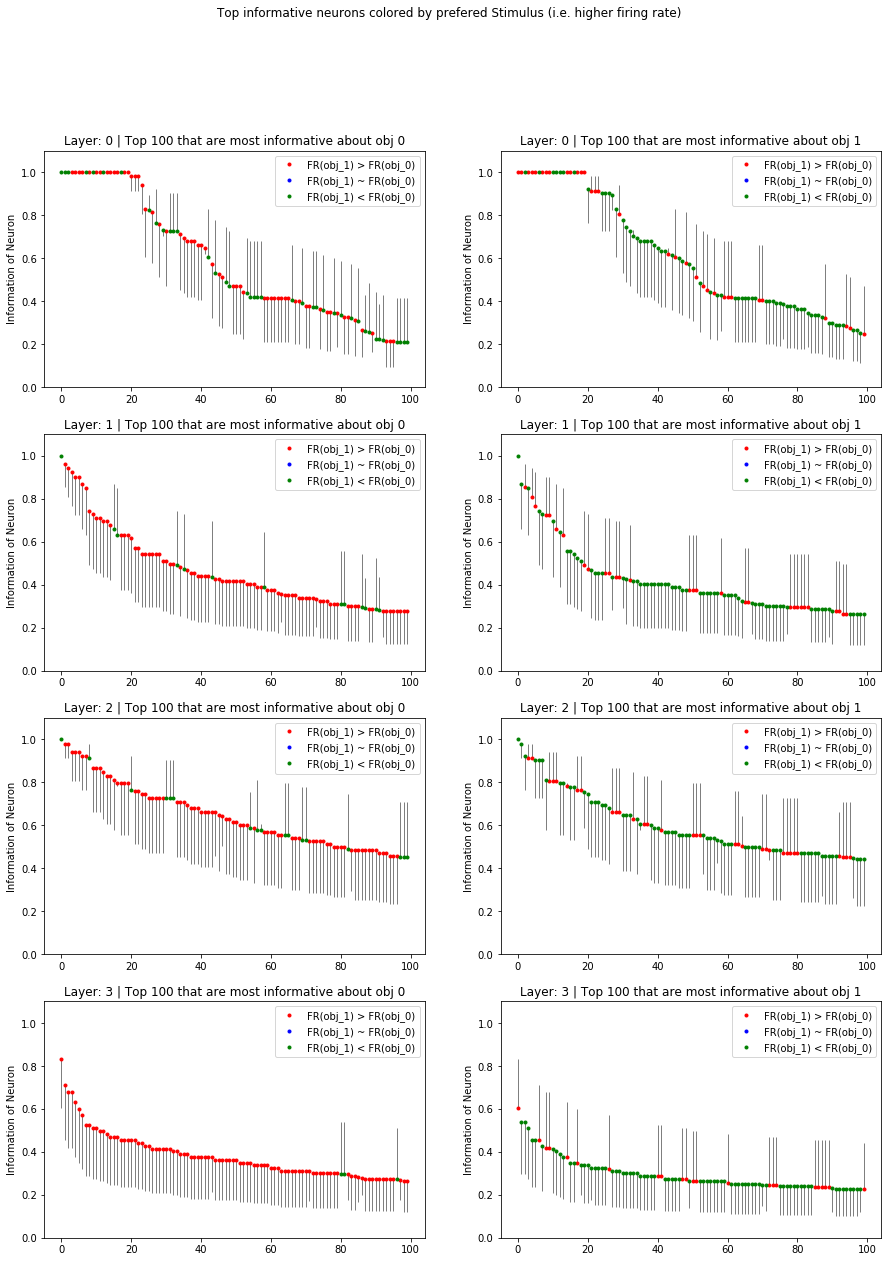

In [138]:
from matplotlib import collections  as mc

n_neurons_to_plot = 100

mean_obj_0 = np.mean(last_epoch_exc[objects_in_training[0], :, :], axis=0)
mean_obj_1 = np.mean(last_epoch_exc[objects_in_training[1], :, :], axis=0)

min_diff_to_count = np.std(last_epoch_exc, axis=0) * 0.8

obj_1_minus_0 = mean_obj_1 - mean_obj_0

obj_1_higher = obj_1_minus_0 > min_diff_to_count # boolean for each neuron. true if that neuron ON AVERAGe has a hihger
# FR for object 1
obj_0_higher  = obj_1_minus_0 < - min_diff_to_count
no_difference = np.invert(obj_1_higher) & np.invert(obj_0_higher) # no difference

assert(np.all(obj_1_higher ^ obj_0_higher ^ no_difference))

# sort them according to information
decreasing_info_ids = np.argsort(info_exc, axis=2)[:, :, :-n_neurons_to_plot-1:-1]
# this has dimensions [object about wich the information cecreases, layer, information rank of neuron with respect to that object]
assert(decreasing_info_ids.shape == (2, 4, n_neurons_to_plot))


n_layers = 4




fig = plt.figure(figsize=(15, 20))
fig.suptitle("Top informative neurons colored by prefered Stimulus (i.e. higher firing rate)")
for l in range(n_layers):
    for obj in range(2):
        neuron_rank = np.arange(n_neurons_to_plot) # we will need this for the x axis
        
        sorted_ids_obj_layer = decreasing_info_ids[obj, l, :]
        informations_obj_layer = info_exc[obj, l, sorted_ids_obj_layer]
        
        axObj = fig.add_subplot(n_layers, 2, l*2 + obj + 1)
        axObj.set_title("Layer: {} | Top {} that are most informative about obj {}".format(l, n_neurons_to_plot, obj))
        axObj.set_ylim(0, 1.1)
        
        # plot neurons that had higher response for object 1
        mask_1_higher = obj_1_higher[l, sorted_ids_obj_layer]
        axObj.plot(neuron_rank[mask_1_higher], informations_obj_layer[mask_1_higher], 'r.', label="FR(obj_1) > FR(obj_0)")
        
        # plot neurons that had higher response for object 0
        mask_no_diff = no_difference[l, sorted_ids_obj_layer]
        axObj.plot(neuron_rank[mask_no_diff], informations_obj_layer[mask_no_diff], 'b.', label="FR(obj_1) ~ FR(obj_0)" )
        
        
        # plot neurons that had higher response for object 0
        mask_0_higher = obj_0_higher[l, sorted_ids_obj_layer]
        axObj.plot(neuron_rank[mask_0_higher], informations_obj_layer[mask_0_higher], 'g.', label="FR(obj_1) < FR(obj_0)")
        
        # plot information of that neuron about the other object
        otherObjID = (obj+1) % 2
        line_list = make_line_collection_list(info_exc[otherObjID, l, sorted_ids_obj_layer], info_exc[obj, l, sorted_ids_obj_layer])
        lc = mc.LineCollection(line_list, colors='black', linewidths=0.5)
        axObj.add_collection(lc)
        
        axObj.set_ylabel("Information of Neuron")
        axObj.legend()
    
    
    


#### Cumsum of neurons with prefered stimuli with decreasing info threshold

In [139]:
n_obj, n_layer, _n_neurons = info_exc.shape

higher_for_1_within_top_i = np.zeros((n_obj, n_layer, n_neurons_to_plot))
# _[obj_id, layer_id, i] number of neurons within the top i most informative(about obj_id) neurons in layer layer_id
# that have a higher fr in response to object 1
higher_for_0_within_top_i = np.zeros((n_obj, n_layer, n_neurons_to_plot))
no_difference_within_top_i  = np.zeros((n_obj, n_layer, n_neurons_to_plot))
print(obj_1_higher.shape)

for obj in range(n_obj):
    for l in range(n_layer):
        for rank in range(n_neurons_to_plot):
            relevant_neurons = decreasing_info_ids[obj, l, :rank+1]
            higher_for_1_within_top_i[obj, l, rank] = np.count_nonzero(obj_1_higher[l, relevant_neurons])
            higher_for_0_within_top_i[obj, l, rank] = np.count_nonzero(obj_0_higher[l, relevant_neurons])
            no_difference_within_top_i[obj, l, rank] = np.count_nonzero(no_difference[l, relevant_neurons])

(4, 4096)


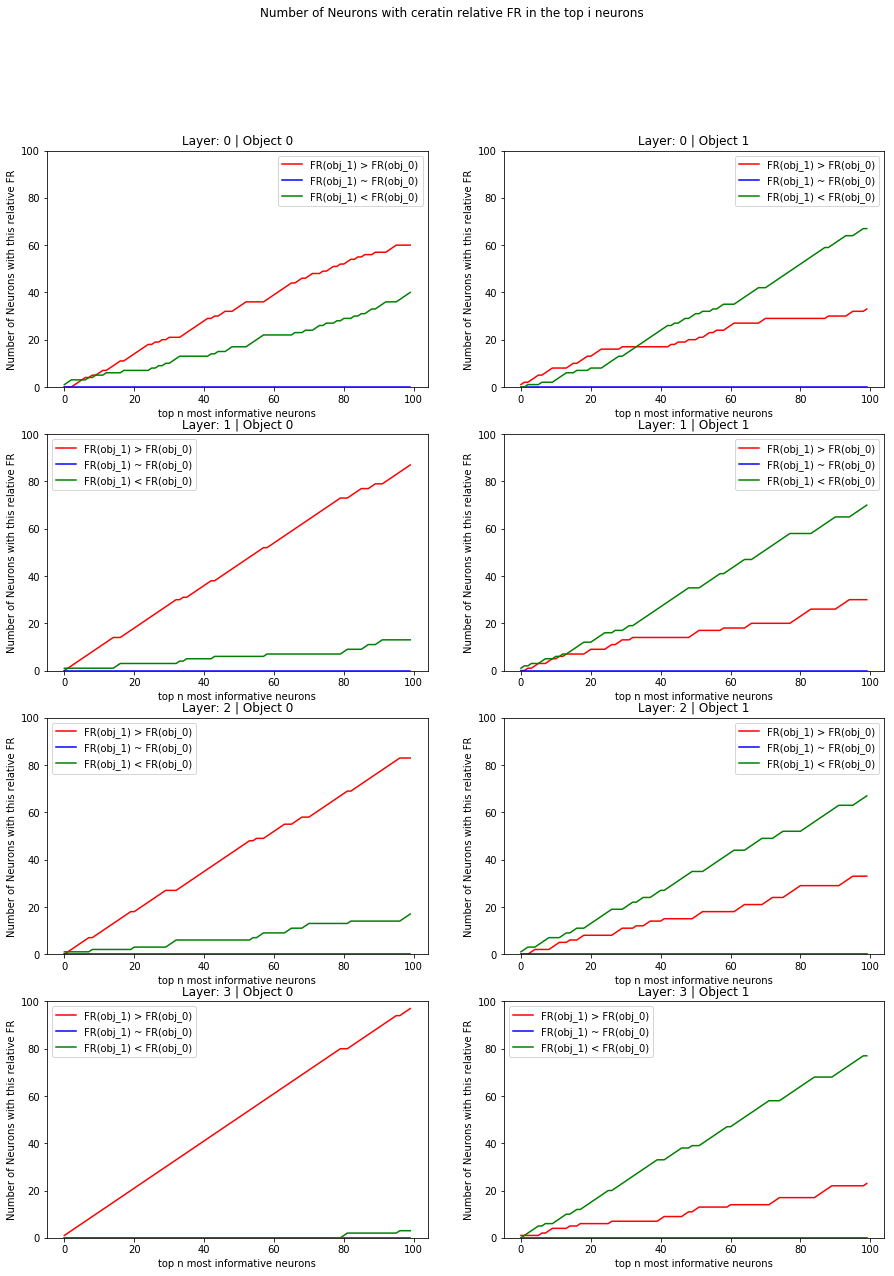

In [140]:
fig = plt.figure(figsize=(15, 20))
fig.suptitle("Number of Neurons with ceratin relative FR in the top i neurons")
for l in range(n_layers):
    for obj in range(2):
        axObj = fig.add_subplot(n_layers, 2, l*2 + obj + 1)
        axObj.set_title("Layer: {} | Object {}".format(l, obj))
        axObj.set_ylim(0, n_neurons_to_plot)
        axObj.set_ylabel("Number of Neurons with this relative FR")
        axObj.set_xlabel("top n most informative neurons")
        

        axObj.plot(higher_for_1_within_top_i[obj, l, :], 'r', label="FR(obj_1) > FR(obj_0)")
        

        axObj.plot(no_difference_within_top_i[obj, l, :], 'b', label="FR(obj_1) ~ FR(obj_0)")
        

        axObj.plot(higher_for_0_within_top_i[obj, l, :], 'g', label="FR(obj_1) < FR(obj_0)")
         
        axObj.legend()

#### Interpretation
<a id="higher_fr_for_obj_0"></a>
FR=0 is the least distributed Firing Rate a neuron can have. Therefore neurons that have FR(obj0)=0 and FR(obj1)=1 have the highest information about object 0. 
-> if obj0 causes less (specific) inhibition, then there will be less neurons that have this kind of response
-> less information about obj0

### Number of neurons by prefered stimulus

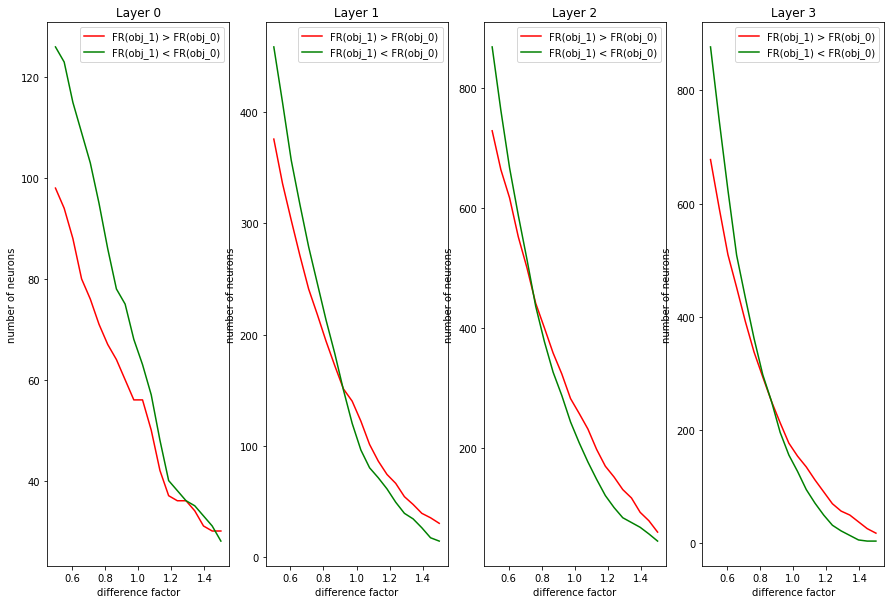

In [141]:
def count_of_neuron_type(difference_factor_list):
    n_neurons_with_fr_high_for_obj_1 = np.zeros((4, len(difference_factor_list)))
    n_neurons_with_fr_high_for_obj_0 = np.zeros((4, len(difference_factor_list)))
    n_neurons_no_diff = np.zeros((4, len(difference_factor_list)))
        
    for i, diff_factor in enumerate(difference_factor_list):

        
        min_diff_to_count = np.std(last_epoch_exc, axis=0) * diff_factor
        
        
        obj_1_minus_0 = mean_obj_1 - mean_obj_0

        obj_1_higher = obj_1_minus_0 > min_diff_to_count # boolean for each neuron. true if that neuron ON AVERAGe has a hihger
        # FR for object 1
        obj_0_higher  = obj_1_minus_0 < - min_diff_to_count
        no_difference = np.invert(obj_1_higher) & np.invert(obj_0_higher) # no difference

        assert(np.all(obj_1_higher ^ obj_0_higher ^ no_difference))

        # count each category within layer, plot threw layer
        n_neurons_with_fr_high_for_obj_1[:, i] = np.count_nonzero(obj_1_higher, axis=1)
        n_neurons_with_fr_high_for_obj_0[:, i] = np.count_nonzero(obj_0_higher, axis=1)
        n_neurons_no_diff[:, i] = np.count_nonzero(no_difference, axis=1)
        
    return n_neurons_with_fr_high_for_obj_0, n_neurons_with_fr_high_for_obj_1, n_neurons_no_diff
    
diff_factor_list = np.linspace(0.5, 1.5, 20)
n_neurons_with_fr_high_for_obj_0, n_neurons_with_fr_high_for_obj_1, _b = count_of_neuron_type(diff_factor_list)
fig = plt.figure("Number of Neurons with prefered stimulus", figsize = (15, 10))
for l in range(4):
    ax = fig.add_subplot(1,4,1+l)
    ax.set_title("Layer {}".format(l))
    ax.set_ylabel("number of neurons")
    ax.set_xlabel("difference factor")
    ax.plot(diff_factor_list, n_neurons_with_fr_high_for_obj_1[l, :], 'r', label="FR(obj_1) > FR(obj_0)")
    #ax.plot(n_neurons_no_diff, 'bx', label="FR(obj_1) ~ FR(obj_0)")
    ax.plot(diff_factor_list, n_neurons_with_fr_high_for_obj_0[l, :], 'g', label="FR(obj_1) < FR(obj_0)")
    #ax.set_yscale("log", nonposy='clip')
    ax.legend()


ok so there are more then enough neurons with FR(obj_0) < FR(obj_1) but the question is wether those where inhibited into this behaiviour by inhibition caused by the border object? (High inhibitory activity for 0 quiets down active neurons).  (lack in inhibition might be seen through not completely 0 fr. )

Or wether it is due to a lack of excitation that the border object provides. 
(lower excitatory and inhibitory activity). (turn off inhibition and see if efect is the same)

#### 